In [1]:
import torch
import keras
from sklearn.model_selection import train_test_split

(train_input, train_target),(test_input, test_target) = keras.datasets.imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(
    train_input,train_target
)

In [2]:
from keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [3]:
train_seq = torch.tensor(train_seq)
val_seq = torch.tensor(val_seq)

In [4]:
train_target = torch.tensor(train_target, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)

In [5]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_seq,train_target)
val_dataset = TensorDataset(val_seq,val_target)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
import torch.nn as nn
class IMDBRnnm(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(500,16)
        self.rnn = nn.RNN(16,8,batch_first=True)
        self.dense = nn.Linear(8,1) 
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.rnn(x)
        outputs = self.dense(hidden[-1])
        return self.sigmoid(outputs)

In [ ]:
from torchinfo import summary
model = IMDBRnnm()
summary(model)

Layer (type:depth-idx)                   Param #
IMDBRnnm                                 --
├─Embedding: 1-1                         8,000
├─RNN: 1-2                               208
├─Linear: 1-3                            9
├─Sigmoid: 1-4                           --
Total params: 8,217
Trainable params: 8,217
Non-trainable params: 0

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

IMDBRnnm(
  (embedding): Embedding(500, 16)
  (rnn): RNN(16, 8, batch_first=True)
  (dense): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [9]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [10]:
train_hist = []
val_hist = []
patience = 3
best_loss = -1
early_stopping_counter = 0
epochs = 100
best_loss = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(),targets)

        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(),targets)
            
            val_loss += loss.item()
        
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_hist.append(train_loss)
    val_hist.append(val_loss)
    print(f"에포크{epoch+1} - 훈련손실:{train_loss}, 검증손실:{val_loss}")
    if best_loss == 0 or val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), "best_rnn_model.pt")
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"{epoch+1}에서 조기종료!")
            break

에포크1 - 훈련손실:0.691845143207511, 검증손실:0.6851465802411644
에포크2 - 훈련손실:0.6740702141470469, 검증손실:0.6677009013234353
에포크3 - 훈련손실:0.649729084948224, 검증손실:0.6435546333692512
에포크4 - 훈련손실:0.6378873845517838, 검증손실:0.6365152466662076
에포크5 - 훈련손실:0.626014795319619, 검증손실:0.629849486509148
에포크6 - 훈련손실:0.6130637909975475, 검증손실:0.6178511285356113
에포크7 - 훈련손실:0.617748387539346, 검증손실:0.6129602510101941
에포크8 - 훈련손실:0.594989248052392, 검증손실:0.6040413125741239
에포크9 - 훈련손실:0.594852933043506, 검증손실:0.6043006954144459
에포크10 - 훈련손실:0.5846030503613143, 검증손실:0.5894299677135993
에포크11 - 훈련손실:0.5858515708519737, 검증손실:0.5852926738408147
에포크12 - 훈련손실:0.5748445123128924, 검증손실:0.5857146044774931
에포크13 - 훈련손실:0.6650177007445703, 검증손실:0.6634817524832122
에포크14 - 훈련손실:0.6366410192369194, 검증손실:0.6303362210794371
14에서 조기종료!


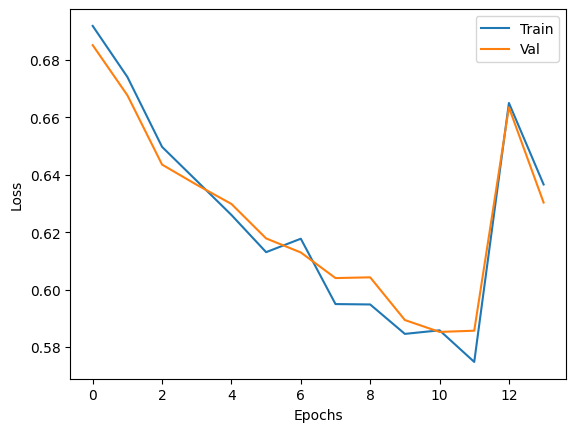

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_hist, label='Train')
plt.plot(val_hist, label='Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
model.load_state_dict(torch.load('best_rnn_model.pt',weights_only=True))

<All keys matched successfully>

In [14]:
model.eval()
correct = 0
with torch.no_grad(): 
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predicts = outputs.squeeze()>0.5
        correct += (predicts == targets).sum().item()

accuracy = correct / len(val_dataset)
print('정확도 =',accuracy)

정확도 = 0.70976
